# Import

In [2]:
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

2025-02-23 16:51:00.008113: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 16:51:00.019440: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 16:51:00.125319: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 16:51:00.224767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740340260.326622    9813 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740340260.35

# Function

In [3]:
def plot_results(history, epochs):
  acc = history.history['Accuracy']
  val_acc = history.history['val_Accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_intervals = range(epochs)
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_intervals, acc, label='Train Accuracy')
  plt.plot(epochs_intervals, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_intervals, loss, label='Train Loss')
  plt.plot(epochs_intervals, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.show()

In [4]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('Accuracy') >= 0.93:
            print('Reach 93% Accuracy! Stop training')
            self.model.stop_training = True

In [6]:
class myCallbackAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('Accuracy') >= 0.999:
            print('Reach 99% Accuracy! Stop training')
            self.model.stop_training = True

# Data

In [7]:
path = '../data/uvas'

In [8]:
data_dir = pathlib.Path(path)

In [12]:
print('Number of images:', len(list(data_dir.glob('*/*.JPG'))))

Number of images: 1600


In [14]:
subfolders = [f.name for f in data_dir.iterdir() if f.is_dir()]
print('Name of subfolders:', subfolders)

Name of subfolders: ['HealthyGrapes', 'LeafBlight', 'BlackRot', 'BlackMeasles']


In [27]:
leafblight = list(data_dir.glob(f'{subfolders[1]}/*'))

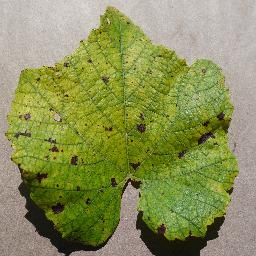

In [42]:
Image.open(str(leafblight[0]))

# Dimension

In [38]:
for subfolder in subfolders:
    path = data_dir / subfolder
    images = list(path.glob('*.JPG'))
    print(f'Subfolder {subfolder} has {len(images)} images')

    if images:
        img = Image.open(str(images[0]))
        img_array = np.array(img)
        print(f'First image dimension in {subfolder}: {img_array.shape}')
        print()

Subfolder HealthyGrapes has 400 images
First image dimension in HealthyGrapes: (256, 256, 3)

Subfolder LeafBlight has 400 images
First image dimension in LeafBlight: (256, 256, 3)

Subfolder BlackRot has 400 images
First image dimension in BlackRot: (256, 256, 3)

Subfolder BlackMeasles has 400 images
First image dimension in BlackMeasles: (256, 256, 3)



Image structure

    (Image pixels, image pixels, channels)

    (256, 256, 3)

Channels is equivalent to the matrix of colors

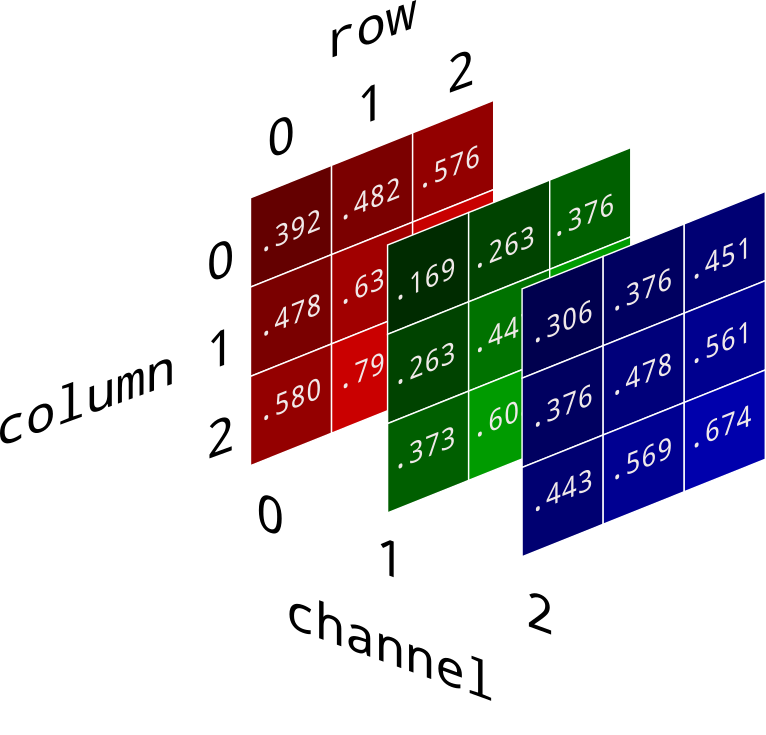

# Model

## Train/ test

In [9]:
batch_size = 64
height = 256
width = 256

In [10]:
validation = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=7,
    image_size=(height, width),
    batch_size=batch_size
)

Found 1600 files belonging to 4 classes.
Using 320 files for validation.


2025-02-23 16:51:20.225545: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=7,
    image_size=(height, width),
    batch_size=batch_size
)

Found 1600 files belonging to 4 classes.
Using 1280 files for training.


## Baseline

In [13]:
# Model achitecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)), # Input Layer
    tf.keras.layers.Rescaling(1./255), # Preprocessing scale
    tf.keras.layers.Flatten(), # Preprocessing to one dimension
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # hiden layer
    tf.keras.layers.Dense(4, activation=tf.nn.softmax) # Output layer for 4 classes
])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,499,406 (288.01 MB)

 Trainable params: 25,166,468 (96.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,332,938 (192.00 MB)

In [24]:
# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [25]:
epochs = 10

# Treinamento
history = model.fit(
    train,
    validation_data=validation,
    epochs=epochs
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - Accuracy: 0.2552 - loss: 77.1801 - val_Accuracy: 0.2656 - val_loss: 7.4758
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - Accuracy: 0.4161 - loss: 4.3030 - val_Accuracy: 0.6438 - val_loss: 1.1228
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - Accuracy: 0.6188 - loss: 1.2606 - val_Accuracy: 0.6875 - val_loss: 0.8705
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - Accuracy: 0.6986 - loss: 0.7918 - val_Accuracy: 0.7094 - val_loss: 0.7754
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - Accuracy: 0.7211 - loss: 0.6929 - val_Accuracy: 0.7844 - val_loss: 0.5480
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - Accuracy: 0.7636 - loss: 0.6037 - val_Accuracy: 0.7500 - val_loss: 0.5815
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - Accuracy: 0.7409 - loss: 0.5936 - val_Accuracy: 0.7656 - val_loss: 0.5674
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - Accuracy: 0.7806 - loss: 0.5580 - val_Accuracy: 0

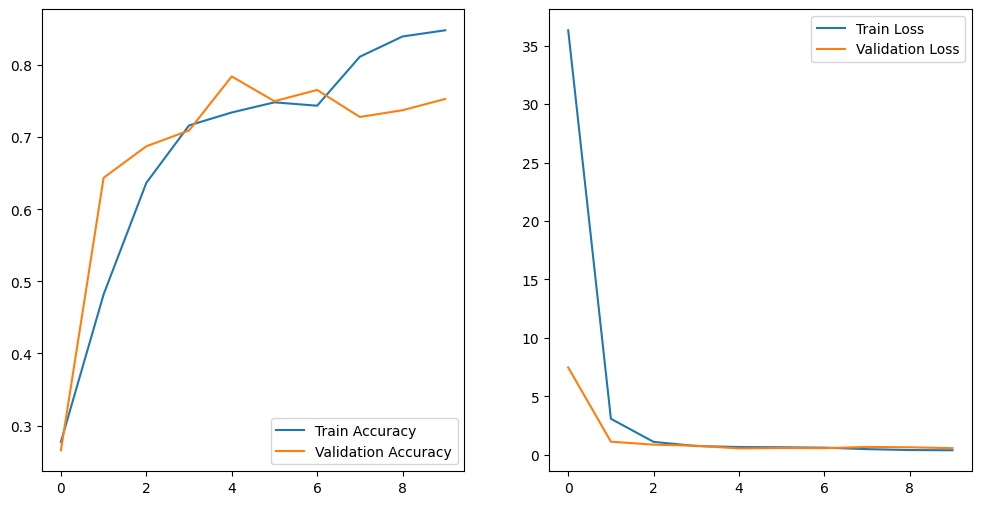

In [35]:
plot_results(history, epochs)

## Conv Layer

Add filter map image and dimensionality reduction

In [12]:
# Model achitecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)), # Input Layer
    tf.keras.layers.Rescaling(1./255), # Preprocessing scale
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), # Conv Layer
    tf.keras.layers.MaxPooling2D(2,2), # Filter the max value
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), # Conv Layer
    tf.keras.layers.MaxPooling2D(2,2), # Filter the max value
    tf.keras.layers.Flatten(), # Preprocessing to one dimension
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # hiden layer
    tf.keras.layers.Dense(4, activation=tf.nn.softmax) # Output layer for 4 classes
])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,755,812 (60.10 MB)

 Trainable params: 15,755,812 (60.10 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [15]:
epochs = 10

# Treinamento
history = model.fit(
    train,
    validation_data=validation,
    epochs=epochs
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 648ms/step - Accuracy: 0.3084 - loss: 6.7191 - val_Accuracy: 0.2875 - val_loss: 1.3127
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 628ms/step - Accuracy: 0.5506 - loss: 1.0473 - val_Accuracy: 0.7500 - val_loss: 0.5475
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 675ms/step - Accuracy: 0.7981 - loss: 0.4733 - val_Accuracy: 0.8062 - val_loss: 0.4513
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 684ms/step - Accuracy: 0.8681 - loss: 0.3663 - val_Accuracy: 0.8406 - val_loss: 0.3944
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 702ms/step - Accuracy: 0.9405 - loss: 0.1948 - val_Accuracy: 0.9031 - val_loss: 0.2673
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 730ms/step - Accuracy: 0.9543 - loss: 0.1368 - val_Accuracy: 0.9125 - val_loss: 0.2413
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 698ms/step - Accuracy: 0.9576 - loss: 0.1239 - val_Accuracy: 0.8969 - val_loss: 0.2604
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 687ms/step - Accuracy: 0.9809 - loss: 0.0810 - val_Accu

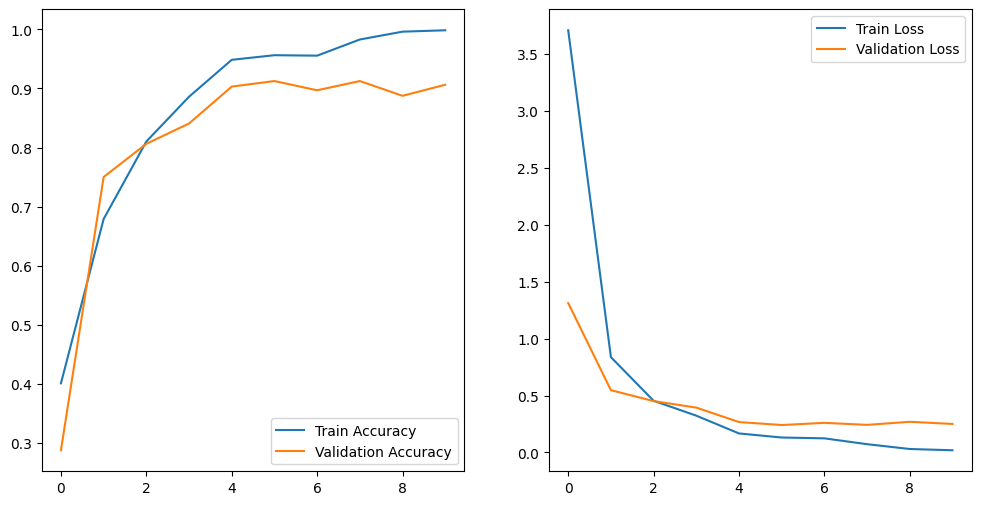

In [16]:
plot_results(history, epochs)

## Callback

Stop training based on criterion

In [29]:
# Model achitecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)), # Input Layer
    tf.keras.layers.Rescaling(1./255), # Preprocessing scale
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), # Conv Layer
    tf.keras.layers.MaxPooling2D(2,2), # Filter the max value
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), # Conv Layer
    tf.keras.layers.MaxPooling2D(2,2), # Filter the max value
    tf.keras.layers.Flatten(), # Preprocessing to one dimension
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # hiden layer
    tf.keras.layers.Dense(4, activation=tf.nn.softmax) # Output layer for 4 classes
])

In [30]:
# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [31]:
epochs = 10

callbacks = myCallback()

# Treinamento
history = model.fit(
    train,
    validation_data=validation,
    epochs=epochs,
    callbacks=[callbacks]
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 675ms/step - Accuracy: 0.3095 - loss: 4.5926 - val_Accuracy: 0.4594 - val_loss: 1.0036
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 683ms/step - Accuracy: 0.7508 - loss: 0.6588 - val_Accuracy: 0.7969 - val_loss: 0.4830
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 669ms/step - Accuracy: 0.8467 - loss: 0.3859 - val_Accuracy: 0.9000 - val_loss: 0.2398
Epoch 4/10
Reach 93% Accuracy! Stop training━━━━━━ 0s 612ms/step - Accuracy: 0.9484 - loss: 0.1377 
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 661ms/step - Accuracy: 0.9491 - loss: 0.1369 - val_Accuracy: 0.8719 - val_loss: 0.2645


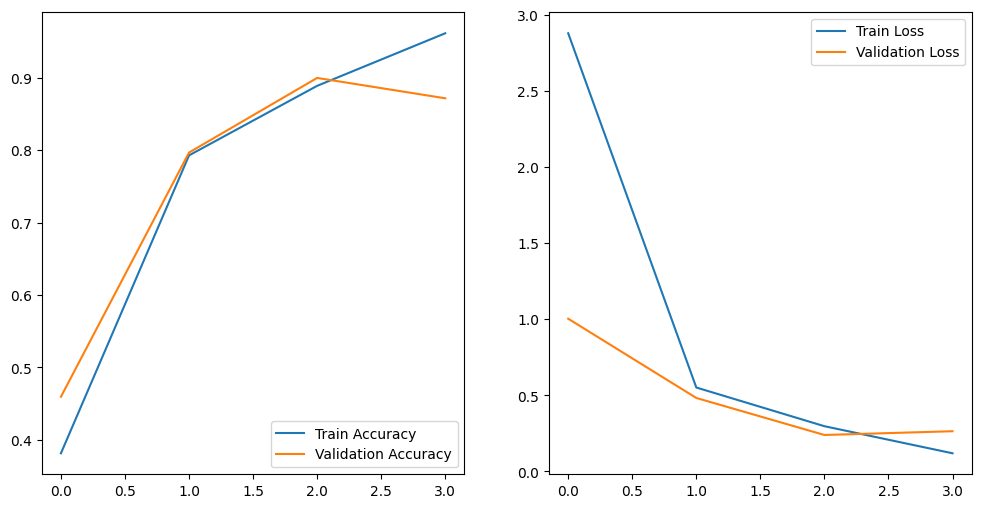

In [33]:
plot_results(history, 4)

## Data Augmentation

Add variation on dataset 

In [34]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05)
])

In [35]:
# Model achitecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)), # Input Layer
    data_augmentation, # Diversity on data
    tf.keras.layers.Rescaling(1./255), # Preprocessing scale
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), # Conv Layer
    tf.keras.layers.MaxPooling2D(2,2), # Filter the max value
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), # Conv Layer
    tf.keras.layers.MaxPooling2D(2,2), # Filter the max value
    tf.keras.layers.Flatten(), # Preprocessing to one dimension
    tf.keras.layers.Dense(128, activation=tf.nn.relu), # hiden layer
    tf.keras.layers.Dense(4, activation=tf.nn.softmax) # Output layer for 4 classes
])

In [36]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,755,812 (60.10 MB)

 Trainable params: 15,755,812 (60.10 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [38]:
epochs = 10

callbacks = myCallback()

# Treinamento
history = model.fit(
    train,
    validation_data=validation,
    epochs=epochs
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 867ms/step - Accuracy: 0.2637 - loss: 5.6333 - val_Accuracy: 0.3875 - val_loss: 1.1502
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 826ms/step - Accuracy: 0.6233 - loss: 1.0081 - val_Accuracy: 0.7625 - val_loss: 0.5696
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 753ms/step - Accuracy: 0.8050 - loss: 0.5542 - val_Accuracy: 0.6781 - val_loss: 0.8956
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 743ms/step - Accuracy: 0.8443 - loss: 0.4000 - val_Accuracy: 0.7156 - val_loss: 1.0071
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 738ms/step - Accuracy: 0.8825 - loss: 0.3040 - val_Accuracy: 0.7500 - val_loss: 0.6539
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 748ms/step - Accuracy: 0.9177 - loss: 0.2487 - val_Accuracy: 0.8250 - val_loss: 0.7044
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 745ms/step - Accuracy: 0.9218 - loss: 0.2216 - val_Accuracy: 0.8000 - val_loss: 0.7083
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 796ms/step - Accuracy: 0.9295 - loss: 0.1883 - val_Accu

In [44]:
model.save('data_augmentation_model.keras')

## Pre-trained model

In [12]:
input_shape = (256, 256, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

In [13]:
base_model.trainable = False

In [8]:
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

### Rescaling

In [14]:
# Rescaling
rescaling = tf.keras.layers.Rescaling(1.0/255)

In [15]:
train_scale = train.map(lambda x, y: (rescaling(x), y))
val_scale = validation.map(lambda x, y: (rescaling(x), y))

### Defined Pre-Trainded Layer

In [16]:
last_layer = base_model.get_layer('mixed7')
print(last_layer, last_layer.output)

<Concatenate name=mixed7, built=True> <KerasTensor shape=(None, 14, 14, 768), dtype=float32, sparse=False, name=keras_tensor_228>


In [17]:
last_output = last_layer.output

### Model

In [18]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

'''
The model is define as input of pre-trained model and the output is our use case classification 
'''
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [19]:
# model.summary()

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['Accuracy'],
    loss='sparse_categorical_crossentropy'
)

In [21]:
epochs = 10

callBackAccuracy = myCallbackAccuracy()

history = model.fit(
    train_scale,
    validation_data=val_scale,
    epochs=epochs,
    callbacks=[callBackAccuracy]
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - Accuracy: 0.6093 - loss: 8.8176 - val_Accuracy: 0.9812 - val_loss: 0.1597
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - Accuracy: 0.9745 - loss: 0.2473 - val_Accuracy: 0.9438 - val_loss: 0.6345
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - Accuracy: 0.9869 - loss: 0.0965 - val_Accuracy: 0.9750 - val_loss: 0.2370
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - Accuracy: 0.9934 - loss: 0.0468 - val_Accuracy: 0.9750 - val_loss: 0.2191
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - Accuracy: 0.9964 - loss: 0.0405 - val_Accuracy: 0.9906 - val_loss: 0.0998
Epoch 6/10
Reach 99% Accuracy! Stop training━━━━━━ 0s 3s/step - Accuracy: 1.0000 - loss: 7.8497e-06  
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - Accuracy: 1.0000 - loss: 7.9778e-06 - val_Accuracy: 0.9812 - val_loss: 0.1422


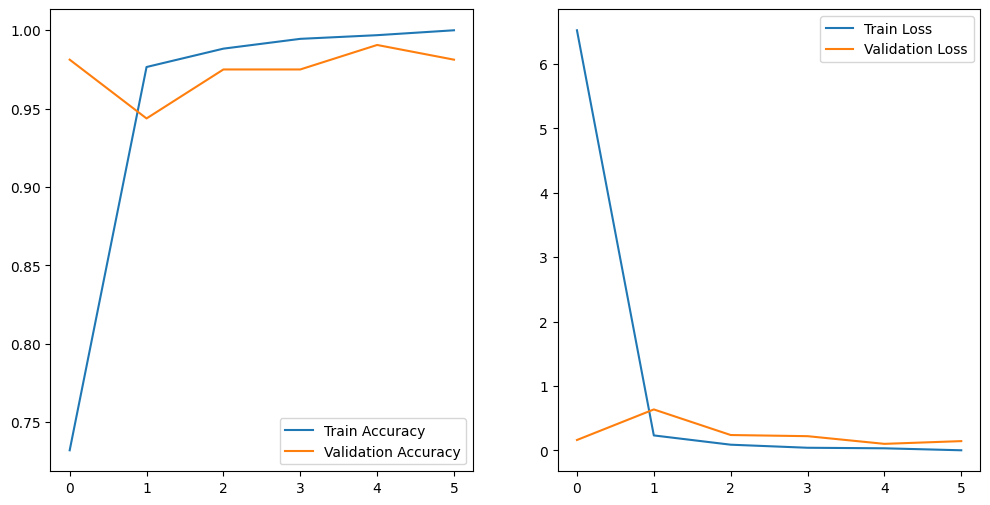

In [22]:
plot_results(history, 6)

In [23]:
model.save('pre_trained_model.keras', include_optimizer=False)

In [23]:
model_converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [24]:
model_converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [25]:
model_converter.target_spec.supported_types = [tf.float16]

In [26]:
model_quant_tflite = model_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpt1ulm6fm/assets


INFO:tensorflow:Assets written to: /tmp/tmpt1ulm6fm/assets


Saved artifact at '/tmp/tmpt1ulm6fm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135813363695440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135813363694672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135813363693712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135813363695248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135813363693328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135813313675728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135813313676880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135813313676304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135813313676688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135813313676496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13581331367803

W0000 00:00:1740340766.970440    9813 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1740340766.970863    9813 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-23 16:59:26.976134: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt1ulm6fm
2025-02-23 16:59:26.985852: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-23 16:59:26.985892: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpt1ulm6fm
I0000 00:00:1740340767.076244    9813 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-02-23 16:59:27.091381: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-23 16:59:29.991994: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpt1ulm6fm
2025-02-23 16:59:30.135468: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [27]:
with open('model_quant_tflite', 'wb') as f:
    f.write(model_quant_tflite)